In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
!pip install split-folders

In [85]:
!pip install torchsummary

In [1]:
import os
import zipfile
import numpy as np
import cv2
import random
import collections
import splitfolders
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
print(os.getcwd())
print(os.listdir())

c:\Users\DMQA\Desktop\workspace\Today-I-Learned\2021-2-TheoryAndApplicationOfDeepLearning
['archive.zip', 'asl_alphabet_dataset', 'asl_alphabet_test', 'asl_alphabet_train', 'Resnet.ipynb', 'Resnet_HW.ipynb', 'test2.py']


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
path_to_zipfile = os.getcwd() + '/archive.zip'
directory_to_extract = os.getcwd()

with zipfile.ZipFile(path_to_zipfile, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract)

In [3]:
def plot_three_samples(letter):
    print("Samples images for letter", letter)
    path = 'C:/Users/DMQA/Desktop/workspace/Today-I-Learned/2021-2-TheoryAndApplicationOfDeepLearning/asl_alphabet_train/asl_alphabet_train/'
    img_path = path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

Samples images for letter A


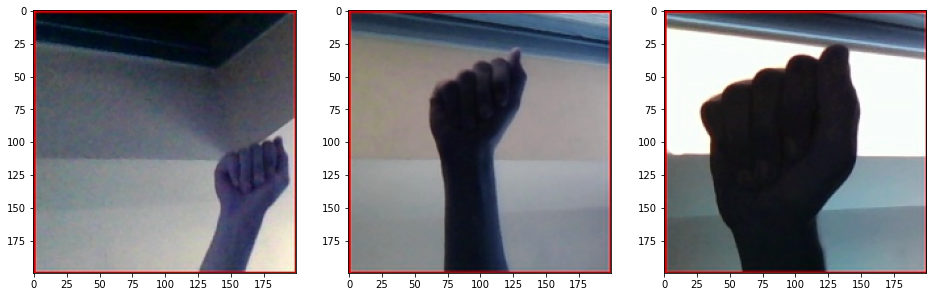

In [4]:
plot_three_samples('A')

In [13]:
splitfolders.ratio(os.getcwd()+'/asl_alphabet_train/asl_alphabet_train', output=os.getcwd()+'/asl_alphabet_dataset', seed=1337, ratio=(0.8,0.1,0.1))

Copying files: 87000 files [12:41, 114.27 files/s]


In [5]:
train_data_path = os.getcwd()+'/asl_alphabet_dataset/train'
test_data_path = os.getcwd()+'/asl_alphabet_dataset/test'
val_data_path = os.getcwd()+'/asl_alphabet_dataset/val'

data_transformer = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_path, transform=data_transformer)
test_dataset = datasets.ImageFolder(test_data_path, transform=data_transformer)
val_dataset = datasets.ImageFolder(val_data_path, transform=data_transformer)

print(train_dataset)
print(test_dataset)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 69600
    Root location: c:\Users\DMQA\Desktop\workspace\Today-I-Learned\2021-2-TheoryAndApplicationOfDeepLearning/asl_alphabet_dataset/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 8700
    Root location: c:\Users\DMQA\Desktop\workspace\Today-I-Learned\2021-2-TheoryAndApplicationOfDeepLearning/asl_alphabet_dataset/test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 8700
    Root location: c:\Users\DMQA\Desktop\workspace\Today-I-Learned\2021-2-TheoryAndApplicationOfDeepLearning/asl_alphabet_dataset/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [6]:
print(dict(collections.Counter(train_dataset.targets)))
print(dict(collections.Counter(test_dataset.targets)))
print(dict(collections.Counter(val_dataset.targets)))


{0: 2400, 1: 2400, 2: 2400, 3: 2400, 4: 2400, 5: 2400, 6: 2400, 7: 2400, 8: 2400, 9: 2400, 10: 2400, 11: 2400, 12: 2400, 13: 2400, 14: 2400, 15: 2400, 16: 2400, 17: 2400, 18: 2400, 19: 2400, 20: 2400, 21: 2400, 22: 2400, 23: 2400, 24: 2400, 25: 2400, 26: 2400, 27: 2400, 28: 2400}
{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300, 10: 300, 11: 300, 12: 300, 13: 300, 14: 300, 15: 300, 16: 300, 17: 300, 18: 300, 19: 300, 20: 300, 21: 300, 22: 300, 23: 300, 24: 300, 25: 300, 26: 300, 27: 300, 28: 300}
{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300, 10: 300, 11: 300, 12: 300, 13: 300, 14: 300, 15: 300, 16: 300, 17: 300, 18: 300, 19: 300, 20: 300, 21: 300, 22: 300, 23: 300, 24: 300, 25: 300, 26: 300, 27: 300, 28: 300}


In [7]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_dataset]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_dataset]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])
val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])


test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_dataset]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_dataset]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])
test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)
print(test_meanR, test_meanG, test_meanB)

0.5195615 0.49977392 0.5145552
0.5190376 0.49879244 0.5135289
0.5146701 0.4950814 0.5097887


In [15]:
train_transformer = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224),transforms.ToTensor(),
                                        transforms.Normalize([train_meanR, train_meanG,train_meanB],[train_stdR, train_stdG, train_stdB])])
val_transformer = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224),transforms.ToTensor(),
                                        transforms.Normalize([val_meanR, val_meanG,val_meanB],[val_stdR, val_stdG, val_stdB])])
test_transformer = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224),transforms.ToTensor(),
                                        transforms.Normalize([test_meanR, test_meanG,test_meanB],[test_stdR, test_stdG, test_stdB])])

train_dataset = datasets.ImageFolder(train_data_path, transform=train_transformer)
test_dataset = datasets.ImageFolder(test_data_path, transform=test_transformer)
val_dataset = datasets.ImageFolder(val_data_path, transform=val_transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [21]:
resnet_18 = models.resnet18(pretrained=True).cuda()
resnet_50 = models.resnet50(pretrained=True).cuda()

print('***************************Resnet 18***************************')
summary(resnet_18,(3,224,224))

print('\n'+'***************************Resnet 50***************************')
summary(resnet_50,(3,224,224))

***************************Resnet 18***************************
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64,

In [22]:
for param in resnet_18.parameters():
  param.requires_grad = False

for param in resnet_50.parameters():
  param.requires_grad = False

resnet18_in_features = resnet_18.fc.in_features
resnet50_in_featuers = resnet_50.fc.in_features

new_resnet18_fc = torch.nn.Sequential(nn.Linear(in_features=resnet18_in_features, out_features=29, bias=True))
new_resnet50_fc = torch.nn.Sequential(nn.Linear(in_features=resnet50_in_featuers, out_features=1000, bias=True), nn.ReLU(inplace=True), nn.Linear(in_features=1000, out_features=29, bias=True))

resnet_18.fc = new_resnet18_fc
resnet_50.fc = new_resnet50_fc

criterion = nn.CrossEntropyLoss()
resnet18_optimizer = optim.Adam(resnet_18.parameters(), lr = 0.001)
resnet50_optimizer = optim.Adam(resnet_50.parameters(), lr = 0.001)


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
r18_print_every = 1000
r18_steps = 0
r18_train_losses, r18_val_losses = [], []

resnet_18.to(device)
for epoch in tqdm(range(10)):
    r18_iterations = 0
    r18_running_loss = 0
    r18_correct_train = 0
    r18_total_train = 0
    r18_start_time = time()
    
    resnet_18.train()
    for i, (images, labels) in enumerate(train_loader):
        r18_steps += 1
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward pass
        output = resnet_18(images)
        r18_loss = criterion(output, labels)
    
        r18_correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        r18_total_train += labels.size(0)
        
        # Backward and optimize
        resnet18_optimizer.zero_grad()
        r18_loss.backward()
        resnet18_optimizer.step()
        
        r18_iterations += 1
        r18_running_loss += r18_loss.item()
        
        if r18_steps % r18_print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{10}]. Batch [{i + 1}]/[{len(train_loader)}]. Train loss {r18_running_loss / r18_steps}.', end=' ')
            print(f'Train acc {r18_correct_train / r18_total_train * 100}.', end=' ')
            with torch.no_grad():
                resnet_18.eval()
                r18_correct_val, r18_total_val = 0, 0
                r18_val_loss = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    output = resnet_18(images)
                    r18_loss = criterion(output, labels)
                    r18_val_loss += r18_loss.item()

                    r18_correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    r18_total_val += labels.size(0)

            print(f'Val loss {r18_val_loss / len(val_loader)}. Val acc {r18_correct_val / r18_total_val * 100}')

            r18_train_losses.append(r18_running_loss / r18_total_train)
            r18_val_losses.append(r18_val_loss / r18_total_val)
        
        
    print(f'Epoch took {time() - r18_start_time}') 
    torch.save(resnet_18, f'checkpoint_{r18_correct_val / r18_total_val * 100:.2f}')

    #https://www.kaggle.com/julichitai/asl-alphabet-classification-using-pytorch

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [1000]/[2175]. Train loss 1.129969768077135. Train acc 74.98125457763672. Val loss 0.5116894289686231. Val acc 87.29244232177734
Epoch [1]/[10]. Batch [2000]/[2175]. Train loss 0.7554258391484618. Train acc 83.0796890258789. Val loss 0.3296703421046813. Val acc 91.74353790283203


 10%|█         | 1/10 [06:46<1:00:59, 406.60s/it]

Epoch took 406.506178855896
Epoch [2]/[10]. Batch [825]/[2175]. Train loss 0.09010271945844094. Train acc 91.46591186523438. Val loss 0.2646472940145823. Val acc 92.4354248046875
Epoch [2]/[10]. Batch [1825]/[2175]. Train loss 0.12426953488774597. Train acc 92.83904266357422. Val loss 0.2101662363375905. Val acc 94.29197692871094


 20%|██        | 2/10 [13:14<52:44, 395.60s/it]  

Epoch took 387.81467509269714
Epoch [3]/[10]. Batch [650]/[2175]. Train loss 0.03274305523261428. Train acc 92.6875. Val loss 0.1850532858436618. Val acc 95.237548828125
Epoch [3]/[10]. Batch [1650]/[2175]. Train loss 0.05752717623331895. Train acc 94.03219604492188. Val loss 0.18379945155384356. Val acc 94.77629089355469


 30%|███       | 3/10 [19:39<45:34, 390.61s/it]

Epoch took 384.57649183273315
Epoch [4]/[10]. Batch [475]/[2175]. Train loss 0.01496820901121412. Train acc 93.22367858886719. Val loss 0.164601710195416. Val acc 95.27214050292969
Epoch [4]/[10]. Batch [1475]/[2175]. Train loss 0.03215096869599074. Train acc 94.76058959960938. Val loss 0.15675550993408224. Val acc 95.1337661743164


 40%|████      | 4/10 [26:04<38:52, 388.68s/it]

Epoch took 385.6062605381012
Epoch [5]/[10]. Batch [300]/[2175]. Train loss 0.006492258779290649. Train acc 93.95833587646484. Val loss 0.15824679631698615. Val acc 95.17989349365234
Epoch [5]/[10]. Batch [1300]/[2175]. Train loss 0.018907946454454212. Train acc 95.5793228149414. Val loss 0.14242996835593147. Val acc 95.6642074584961


 50%|█████     | 5/10 [32:06<31:34, 378.85s/it]

Epoch took 361.326224565506
Epoch [6]/[10]. Batch [125]/[2175]. Train loss 0.002122966733168472. Train acc 94.05000305175781. Val loss 0.14996508498267164. Val acc 95.3413314819336
Epoch [6]/[10]. Batch [1125]/[2175]. Train loss 0.012384834729445477. Train acc 95.9527816772461. Val loss 0.13879483957462205. Val acc 95.50276947021484
Epoch [6]/[10]. Batch [2125]/[2175]. Train loss 0.02150939268188981. Train acc 95.90735626220703. Val loss 0.13566351666482943. Val acc 95.64114379882812


 60%|██████    | 6/10 [38:41<25:37, 384.48s/it]

Epoch took 395.3447587490082
Epoch [7]/[10]. Batch [950]/[2175]. Train loss 0.011298003956808576. Train acc 94.6710433959961. Val loss 0.1334456038039274. Val acc 95.74492645263672
Epoch [7]/[10]. Batch [1950]/[2175]. Train loss 0.018355698209193846. Train acc 95.52243041992188. Val loss 0.12201227491027315. Val acc 96.02168273925781


 70%|███████   | 7/10 [44:44<18:52, 377.34s/it]

Epoch took 362.5435287952423
Epoch [8]/[10]. Batch [775]/[2175]. Train loss 0.007762995693949051. Train acc 94.82258605957031. Val loss 0.11670262665518756. Val acc 95.9524917602539
Epoch [8]/[10]. Batch [1775]/[2175]. Train loss 0.013647599703029674. Train acc 95.7623291015625. Val loss 0.10904950538402719. Val acc 96.58671569824219


 80%|████████  | 8/10 [50:51<12:28, 374.20s/it]

Epoch took 367.3867576122284
Epoch [9]/[10]. Batch [600]/[2175]. Train loss 0.0049898614208213985. Train acc 95.07292175292969. Val loss 0.11166890670040217. Val acc 96.47140502929688
Epoch [9]/[10]. Batch [1600]/[2175]. Train loss 0.010079594477153335. Train acc 96.171875. Val loss 0.10941839018128675. Val acc 96.52906036376953


 90%|█████████ | 9/10 [57:06<06:14, 374.21s/it]

Epoch took 374.1518864631653
Epoch [10]/[10]. Batch [425]/[2175]. Train loss 0.0032323727929499. Train acc 94.84558868408203. Val loss 0.11425072547715033. Val acc 96.42527770996094
Epoch [10]/[10]. Batch [1425]/[2175]. Train loss 0.00803634544471944. Train acc 96.17105865478516. Val loss 0.10452507462050092. Val acc 96.6559066772461


100%|██████████| 10/10 [1:03:29<00:00, 380.99s/it]

Epoch took 383.7759759426117


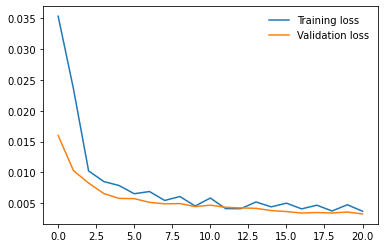

In [25]:
plt.plot(r18_train_losses, label='Training loss')
plt.plot(r18_val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [26]:
with torch.no_grad():
  resnet_18.eval()
  r18_correct_test, r18_total_test = 0, 0
  r18_test_loss = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = resnet_18(images)
    r18_cost = criterion(output, labels)
    r18_test_loss += r18_cost.item()

  r18_correct_test += (torch.max(output, dim=1)[1] == labels).sum()
  r18_total_test += labels.size(0)

print(f'Test loss {r18_test_loss / len(test_loader)}. Test acc {r18_correct_test / r18_total_test * 100}')

Test loss 0.10507646472471667. Test acc 96.875


In [28]:
r50_print_every = 1000
r50_steps = 0
r50_train_losses, r50_val_losses = [], []

resnet_50.to(device)
for epoch in tqdm(range(10)):
    r50_iterations = 0
    r50_running_loss = 0
    r50_correct_train = 0
    r50_total_train = 0
    r50_start_time = time()
    
    resnet_50.train()
    for i, (images, labels) in enumerate(train_loader):
        r50_steps += 1
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward pass
        output = resnet_50(images)
        r50_loss = criterion(output, labels)
    
        r50_correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        r50_total_train += labels.size(0)
        
        # Backward and optimize
        resnet50_optimizer.zero_grad()
        r50_loss.backward()
        resnet50_optimizer.step()
        
        r50_iterations += 1
        r50_running_loss += r50_loss.item()
        
        if r50_steps % r50_print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{10}]. Batch [{i + 1}]/[{len(train_loader)}]. Train loss {r50_running_loss / r50_steps}.', end=' ')
            print(f'Train acc {r50_correct_train / r50_total_train * 100}.', end=' ')
            with torch.no_grad():
                resnet_50.eval()
                r50_correct_val, r50_total_val = 0, 0
                r50_val_loss = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    output = resnet_50(images)
                    r50_loss = criterion(output, labels)
                    r50_val_loss += r50_loss.item()

                    r50_correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    r50_total_val += labels.size(0)

            print(f'Val loss {r50_val_loss / len(val_loader)}. Val acc {r50_correct_val / r50_total_val * 100}')

            r50_train_losses.append(r50_running_loss / r50_total_train)
            r50_val_losses.append(r50_val_loss / r50_total_val)
        
        
    print(f'Epoch took {time() - r50_start_time}') 
    torch.save(resnet_50, f'resnet50_checkpoint_{r50_correct_val / r50_total_val * 100:.2f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [1000]/[2175]. Train loss 0.5281932819038629. Train acc 82.72500610351562. Val loss 0.4309402193970346. Val acc 85.98939514160156
Epoch [1]/[10]. Batch [2000]/[2175]. Train loss 0.4135987474340945. Train acc 86.40625762939453. Val loss 0.2849881893841763. Val acc 90.47509765625
Epoch took 656.4613318443298


 10%|█         | 1/10 [10:56<1:38:30, 656.68s/it]

Epoch [2]/[10]. Batch [825]/[2175]. Train loss 0.09105753057946761. Train acc 88.75757598876953. Val loss 0.25193934903456056. Val acc 91.5129165649414
Epoch [2]/[10]. Batch [1825]/[2175]. Train loss 0.12137996879313141. Train acc 90.98287963867188. Val loss 0.20697005361840953. Val acc 93.00045776367188
Epoch took 644.2401592731476


 20%|██        | 2/10 [21:41<1:26:35, 649.49s/it]

Epoch [3]/[10]. Batch [650]/[2175]. Train loss 0.035400132258050145. Train acc 90.87980651855469. Val loss 0.186209088370094. Val acc 93.62315368652344
Epoch [3]/[10]. Batch [1650]/[2175]. Train loss 0.057724769216806936. Train acc 92.85795593261719. Val loss 0.17055954719202876. Val acc 94.04981994628906
Epoch took 640.7363278865814


 30%|███       | 3/10 [32:22<1:15:19, 645.59s/it]

Epoch [4]/[10]. Batch [475]/[2175]. Train loss 0.016013677738739976. Train acc 91.89473724365234. Val loss 0.16302069546689188. Val acc 94.16513061523438
Epoch [4]/[10]. Batch [1475]/[2175]. Train loss 0.033186387146764904. Train acc 93.76483154296875. Val loss 0.15178145444178714. Val acc 94.91466522216797


 40%|████      | 4/10 [42:57<1:04:08, 641.45s/it]

Epoch took 634.8996689319611
Epoch [5]/[10]. Batch [300]/[2175]. Train loss 0.007065488817273743. Train acc 92.90625762939453. Val loss 0.18530367974903283. Val acc 93.62315368652344
Epoch [5]/[10]. Batch [1300]/[2175]. Train loss 0.019477347378921695. Train acc 94.89904022216797. Val loss 0.14416617994124545. Val acc 95.39898681640625


 50%|█████     | 5/10 [52:57<52:12, 626.50s/it]  

Epoch took 599.7907612323761
Epoch [6]/[10]. Batch [125]/[2175]. Train loss 0.0021224128981544212. Train acc 94.00000762939453. Val loss 0.12118417240259997. Val acc 95.89483642578125
Epoch [6]/[10]. Batch [1125]/[2175]. Train loss 0.011934824721761592. Train acc 95.56944274902344. Val loss 0.14044131646173358. Val acc 95.21448516845703
Epoch [6]/[10]. Batch [2125]/[2175]. Train loss 0.020785871012342305. Train acc 95.67205810546875. Val loss 0.11789531196550057. Val acc 95.67573547363281


 60%|██████    | 6/10 [1:04:02<42:39, 639.78s/it]

Epoch took 665.3612751960754
Epoch [7]/[10]. Batch [950]/[2175]. Train loss 0.012488588631834968. Train acc 93.9868392944336. Val loss 0.08707923655625006. Val acc 97.32472229003906
Epoch [7]/[10]. Batch [1950]/[2175]. Train loss 0.01904380174279019. Train acc 95.150634765625. Val loss 0.2183071583693304. Val acc 93.61161804199219
Epoch took 625.8978219032288


 70%|███████   | 7/10 [1:14:28<31:45, 635.32s/it]

Epoch [8]/[10]. Batch [775]/[2175]. Train loss 0.007612852285732516. Train acc 94.5967788696289. Val loss 0.08539050561161128. Val acc 97.00184631347656
Epoch [8]/[10]. Batch [1775]/[2175]. Train loss 0.013276653188534136. Train acc 95.62500762939453. Val loss 0.127258462015182. Val acc 95.91790008544922


 80%|████████  | 8/10 [1:25:08<21:13, 636.63s/it]

Epoch took 639.2271912097931
Epoch [9]/[10]. Batch [600]/[2175]. Train loss 0.005742232249622854. Train acc 94.45833587646484. Val loss 0.10178899174346502. Val acc 96.33302307128906
Epoch [9]/[10]. Batch [1600]/[2175]. Train loss 0.010446233922603394. Train acc 95.84765625. Val loss 0.0860796790661091. Val acc 97.20941162109375
Epoch took 617.6645338535309


 90%|█████████ | 9/10 [1:35:26<10:30, 630.76s/it]

Epoch [10]/[10]. Batch [425]/[2175]. Train loss 0.0034369094161782413. Train acc 94.86029052734375. Val loss 0.0901489746473331. Val acc 97.03643798828125
Epoch [10]/[10]. Batch [1425]/[2175]. Train loss 0.007491048440779282. Train acc 96.37938690185547. Val loss 0.14547238620152744. Val acc 95.44511413574219
Epoch took 623.5912024974823


100%|██████████| 10/10 [1:45:49<00:00, 635.00s/it]


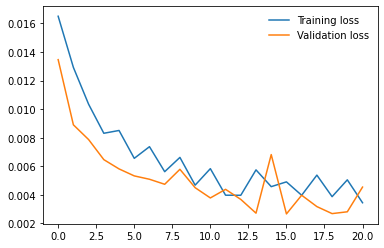

In [29]:
plt.plot(r50_train_losses, label='Training loss')
plt.plot(r50_val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [30]:
with torch.no_grad():
  resnet_50.eval()
  r50_correct_test, r50_total_test = 0, 0
  r50_test_loss = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = resnet_50(images)
    r50_test_cost = criterion(output, labels)
    r50_test_loss += r50_test_cost.item()

  r50_correct_test += (torch.max(output, dim=1)[1] == labels).sum()
  r50_total_test += labels.size(0)

print(f'Test loss {r50_test_loss / len(test_loader)}. Test acc {r50_correct_test / r50_total_test * 100}')

Test loss 0.11890877626717737. Test acc 93.75


In [ ]:
#https://deep-learning-study.tistory.com/534